작성자 : 최승희

# 딥러닝 모델을 통한 영천댐의 댐 유입량 예측


1. folium으로 위치 시각화
2. 다 하고 모델에 SHAP 써보기

데이터 : K-water 댐 수문자료 -> 영천댐

https://www.water.or.kr/realtime/sub01/sub01/dam/hydr.do?s_mid=1332&seq=1408&p_group_seq=1407&menu_mode=3#this

2000년 ~ 2020년 영천댐 일자별 현황 데이터를 이용하였다.


In [ ]:
pip install folium

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import sys, os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm

import folium

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

np.random.seed(777)

## folium을 이용한 영천댐 시각화

In [ ]:
m = folium.Map([36.075, 129.02])

In [ ]:
m.save("index.html")

In [ ]:
map =folium.Map(location = [36.075, 129.02], zoom_start = 13)

마커 표시

In [ ]:
marker = folium.Marker([36.063238907811325, 129.013854000583], 
                       popup = 'campus seven',
                       icon = folium.Icon(color = 'red'))
marker.add_to(map)
map

## 데이터 다운로드

In [ ]:
os.chdir('/content/drive/MyDrive/2021/postech')

In [ ]:
data = pd.read_csv('./dam_data.csv', header = 2, encoding = 'UTF-8')

## 데이터 전처리

1. column 명 변경
2. '일시' 데이터 타입 datetime으로 변환

**column 설명**
- 일시
- 댐수위(EL.m)
- 방수로수위(EL.m)
- 저수량(백만㎥) : 계획홍수위 기준 저수량
- 저수율(%) : 계획홍수위 기준 저수용량에 대한 저수율 적용
- 강우량(mm)
- 유입량(㎥/s) : 댐유역 및 댐의 외부에서 유입되는 유입량의 합 (상류 시설물의 유역에서 유출되는 유량)
- 자체유입(㎥/s) : 외부유입량이 없는 댐유역에서만 유출되는 유량 (해당 시설물 전체 유역의 유출 유량 - 상류 시설물 유역의 유출 유량)
- 영천도수로유입(㎥/s) : 영천 도수로를 통해 유입되는 량
- 총방류량(㎥/s)
- 발전(㎥/s)
- 월류량(㎥/s) : 댐에 저장되어 있는 물이 넘쳐흐른 물의 양
- 하천유지(㎥/s) : 하천의 정상적인 기능 및 상태를 유지하기 위하여 사용한 용수
- 임고(정) ￠900(㎥/s) : 임고정수장
- 수문방류(㎥/s)
- 포항공업용수(㎥/s)
- 학야(정) ￠1200(㎥/s) : 학야정수장
- 양덕(정) ￠1100(㎥/s) : 양덕정수장

*EL.m : 수위 단위*
*자체유입량 = 총방류량 - 외부유입량*

In [ ]:
data = data.rename(columns = {'일시' : '일시', '댐수위(EL.m)' : '댐수위', '방수로수위(EL.m)' : '방수로수위', '저수량(백만㎥)' : '저수량', '저수율(%)' : '저수율', '강우량(mm)' : '강우량',
                              '유입량(㎥/s)' : '유입량', '자체유입(㎥/s)' : '자체유입', '영천도수로유입(㎥/s)' : '영천도수로유입', '총방류량(㎥/s)' : '총방류량', '발전(㎥/s)' : '발전',
                              '월류량(㎥/s)' : '월류량', '하천유지(㎥/s)' : '하천유지', '임고(정) ￠900(㎥/s)' : '임고', '수문방류(㎥/s)' : '수문방류', '포항공업용수(㎥/s)': '포항공업용수',
                              '학야(정) ￠1200(㎥/s)' : '학야', '양덕(정) ￠1100(㎥/s)' : '양덕'})
data['일시'] = pd.to_datetime(data['일시'])
data = data.set_index('일시')
data = data.asfreq('D')
data.head()

,댐수위,방수로수위,저수량,저수율,강우량,유입량,자체유입,영천도수로유입,총방류량,발전,월류량,하천유지,임고,수문방류,포항공업용수,학야,양덕,Unnamed: 18,Unnamed: 19
일시,,,,,,,,,,,,,,,,,,,
2000-01-01,153.24,0.0,66.857,72.6,0.0,0.00,-3.346,0.0,2.76,0.0,0.0,0.463,0.000,0.0,2.293,0.0,0.0,NaN,NaN
2000-01-02,153.17,0.0,66.489,72.2,0.2,0.00,-1.314,0.0,2.94,0.0,0.0,0.451,0.000,0.0,2.490,0.0,0.0,NaN,NaN
2000-01-03,153.13,0.0,66.280,72.0,0.0,0.73,0.731,0.0,3.16,0.0,0.0,0.451,0.000,0.0,2.706,0.0,0.0,NaN,NaN
2000-01-04,153.08,0.0,66.018,71.8,0.0,0.23,0.231,0.0,3.26,0.0,0.0,0.463,0.000,0.0,2.794,0.0,0.0,NaN,NaN
2000-01-05,153.03,0.0,65.757,71.5,4.4,0.17,0.174,0.0,3.19,0.0,0.0,0.000,0.463,0.0,2.730,0.0,0.0,NaN,NaN


dummy column이 존재하여 해당 column을 삭제해준다.

In [ ]:
data = data.drop(columns = ['Unnamed: 18', 'Unnamed: 19'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7671 entries, 2000-01-01 to 2020-12-31
Freq: D
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   댐수위      7671 non-null   float64
 1   방수로수위    7671 non-null   float64
 2   저수량      7671 non-null   float64
 3   저수율      7671 non-null   float64
 4   강우량      7671 non-null   float64
 5   유입량      7671 non-null   float64
 6   자체유입     7671 non-null   float64
 7   영천도수로유입  7671 non-null   float64
 8   총방류량     7671 non-null   float64
 9   발전       7671 non-null   float64
 10  월류량      7671 non-null   float64
 11  하천유지     7671 non-null   float64
 12  임고       7671 non-null   float64
 13  수문방류     7671 non-null   float64
 14  포항공업용수   7671 non-null   float64
 15  학야       7671 non-null   float64
 16  양덕       7671 non-null   float64
dtypes: float64(17)
memory usage: 1.1 MB


matplotlib에서 한글폰트 깨짐현상 해결

In [ ]:
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 48
nanum_font number: 31


In [ ]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.

In [ ]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumBarunGothic


In [ ]:
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
corr = data.corr(method = 'pearson')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


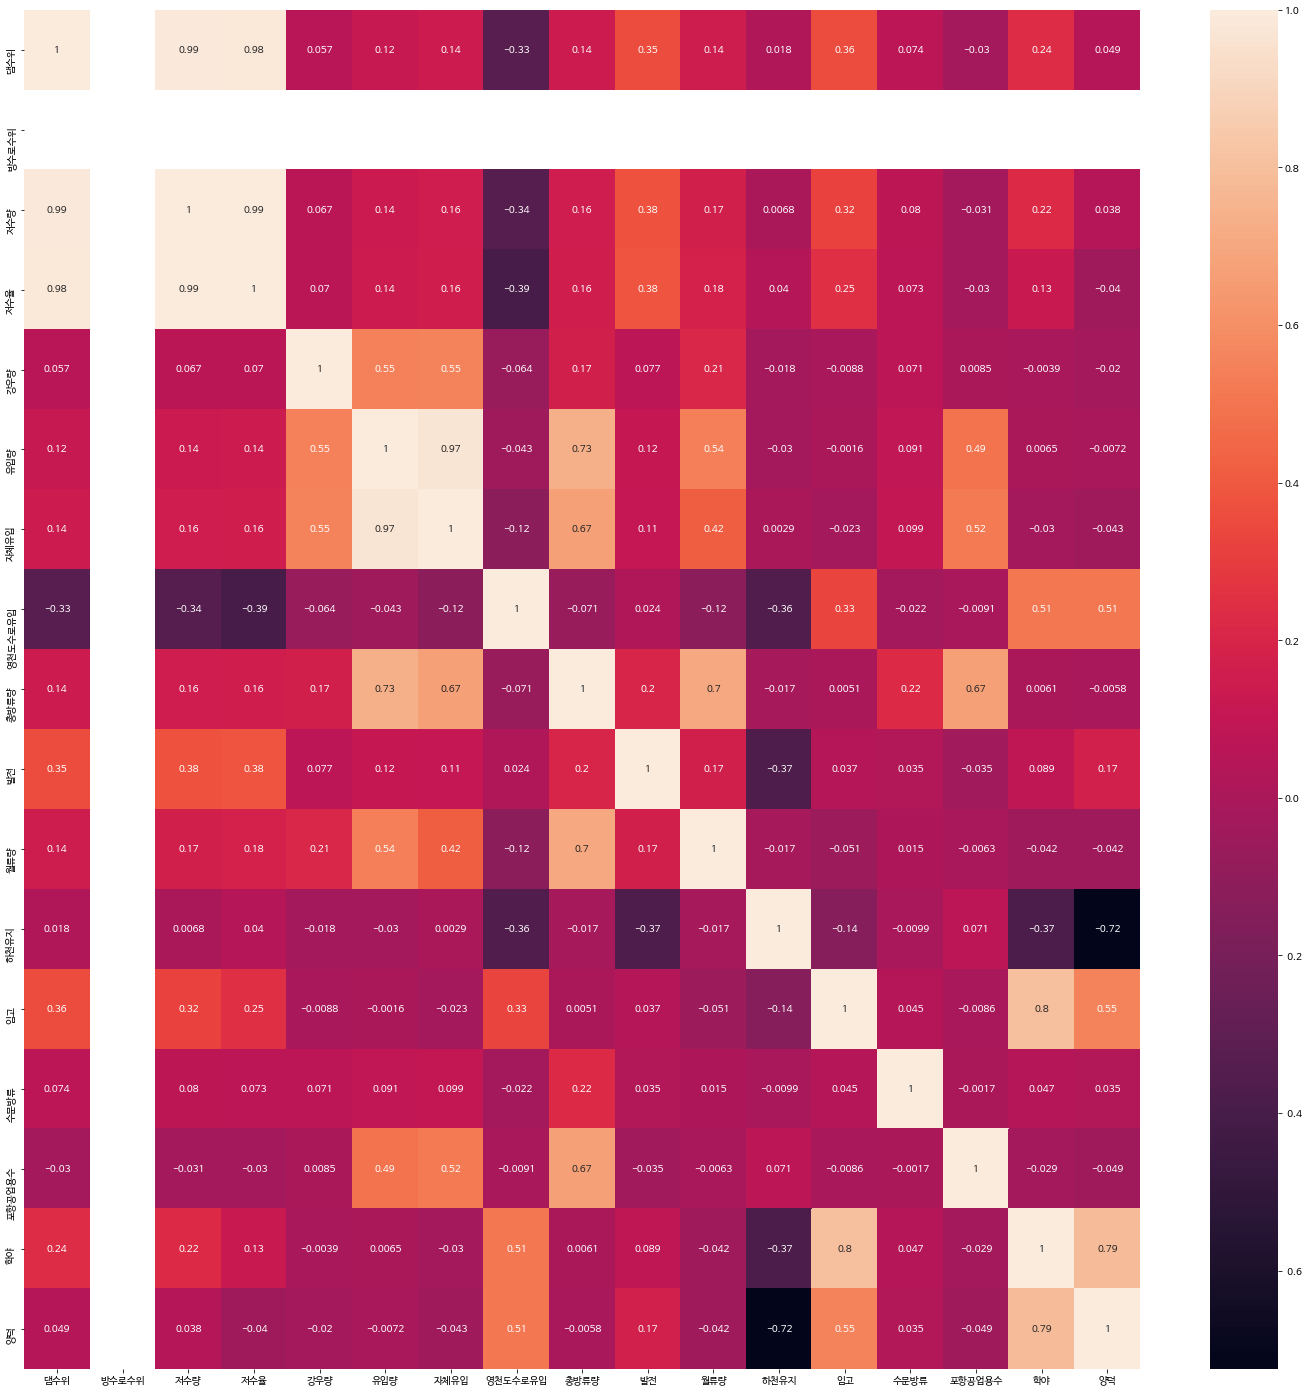

In [ ]:
plt.figure(figsize = (25, 25))
data_heatmap = sns.heatmap(corr, cbar = True, annot = True)

위 데이터에서 방수로수위가 전부 0으로, corr을 측정할 수 없다.

유입량의 상관계수가 높은 항목들 중 '월류량', '총방류량', '자체유입', '강우량'을 선택하였다.

In [ ]:
wanted_col = ['유입량', '월류량', '총방류량', '자체유입', '강우량']
wanted_data = data[wanted_col]
print(wanted_data)

             유입량  월류량  총방류량   자체유입  강우량
일시                                     
2000-01-01  0.00  0.0  2.76 -3.346  0.0
2000-01-02  0.00  0.0  2.94 -1.314  0.2
2000-01-03  0.73  0.0  3.16  0.731  0.0
2000-01-04  0.23  0.0  3.26  0.231  0.0
2000-01-05  0.17  0.0  3.19  0.174  4.4
...          ...  ...   ...    ...  ...
2020-12-27  6.54  0.0  8.18  1.824  0.0
2020-12-28  5.42  0.0  8.15  0.707  0.0
2020-12-29  4.52  0.0  8.34 -0.188  0.2
2020-12-30  5.34  0.0  8.60  0.625  0.0
2020-12-31  5.19  0.0  8.45  0.476  0.0

[7671 rows x 5 columns]


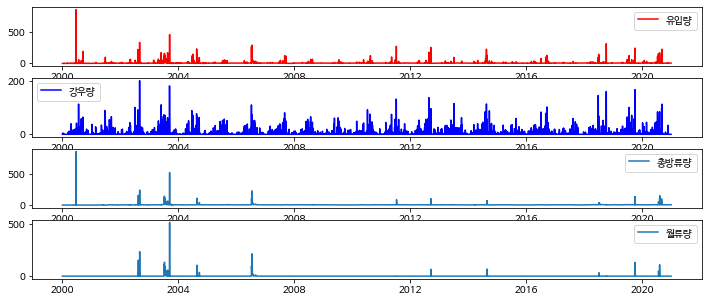

In [ ]:
plt.figure(figsize = (12, 5))

fig1 = plt.subplot(4, 1, 1)
fig1.plot(data['유입량'], color = 'red')
fig1.legend(['유입량'])

fig2 = plt.subplot(4, 1, 2)
fig2.plot(data['강우량'], color = 'blue')
fig2.legend(['강우량'])

fig3 = plt.subplot(4, 1, 3)
fig3.plot(data['총방류량'])
fig3.legend(['총방류량'])

fig4 = plt.subplot(4, 1, 4)
fig4.plot(data['월류량'])
fig4.legend(['월류량'])

## statsmodel을 이용한 데이터 분석

In [ ]:
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools

Seasonal Decomposition

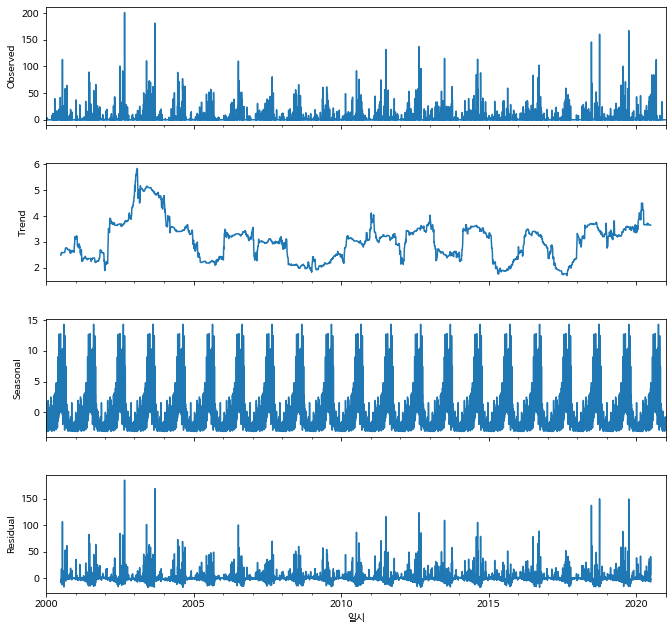

일시
2001-01-05    3.128533
2001-01-06    3.128533
2001-01-07    3.128533
2001-01-08    3.129891
2001-01-09    3.171332
                ...   
2020-12-27         NaN
2020-12-28         NaN
2020-12-29         NaN
2020-12-30         NaN
2020-12-31         NaN
Freq: D, Name: 강우량, Length: 7301, dtype: float64


In [ ]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(data['강우량'], model = 'additive', freq = 368) # annual
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()
print(decomposition.trend[370::])

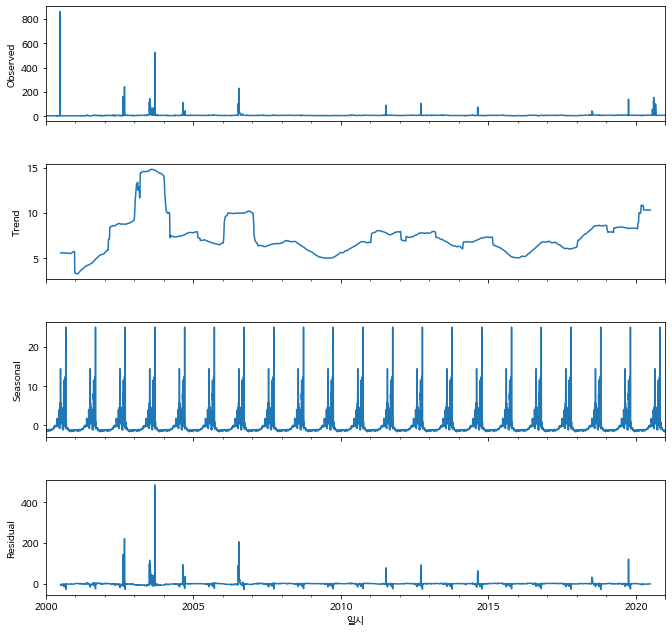

In [ ]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(data['총방류량'], freq = 368 )
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

ACF, PACF

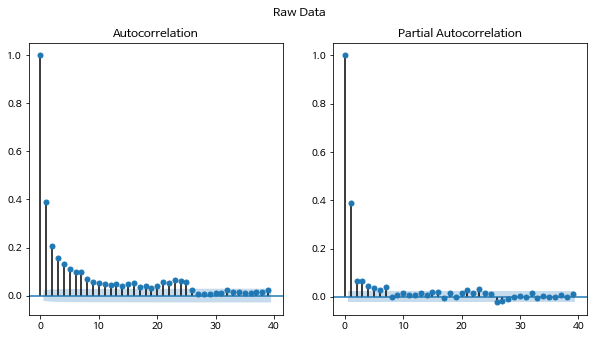

In [ ]:
# ACF, PACF Plot

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(data['유입량'],ax = ax[0])  # Autocorrelation
sm.graphics.tsa.plot_pacf(data['유입량'],ax = ax[1]); # Partial Autocorrelation

## Train-Test set으로 나누기

In [ ]:
# 특정 시점을 기준으로 train set과 test set으로 나눈다.
def train_test_split(given, x_col, y_col, criteria):
  train = given.loc[given.index < criteria, :]
  test = given.loc[given.index >= criteria, :]
  x_train = train[x_col]
  y_train = train[y_col]
  x_test = test[x_col]
  y_test = test[y_col]
  print('x_train size : ', x_train.shape, 'x_test size : ', x_test.shape)
  print('y_train size : ', y_train.shape, 'y_test size : ', y_test.shape)
  return x_train, x_test, y_train, y_test

In [ ]:
x_col = ['총방류량', '월류량', '자체유입', '강우량']
y_col = ['유입량']
criteria = '2020-01-01'
x_train, x_test, y_train, y_test = train_test_split(data, x_col, y_col, criteria)

x_train size :  (7305, 4) x_test size :  (366, 4)
y_train size :  (7305, 1) y_test size :  (366, 1)


## Differencing

In [ ]:
diff_train = x_train.copy()
diff_train = diff_train.diff(2)
diff_train = diff_train.dropna()
diff_train

,총방류량,월류량,자체유입,강우량
일시,,,,
2000-01-03,0.40,0.0,4.077,0.0
2000-01-04,0.32,0.0,1.545,-0.2
2000-01-05,0.03,0.0,-0.557,4.4
2000-01-06,-0.14,0.0,-0.730,0.5
2000-01-07,0.24,0.0,0.255,-4.4
...,...,...,...,...
2019-12-27,-0.02,0.0,-0.012,0.0
2019-12-28,-0.01,0.0,1.174,-1.1
2019-12-29,-0.01,0.0,0.001,3.4


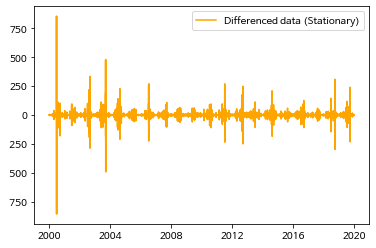

In [ ]:
plt.plot(diff_train, 'orange') # first difference ( t - (t - 1))
plt.legend(['Differenced data (Stationary)'])
plt.show()

In [ ]:
print(diff_train)

            총방류량  월류량   자체유입  강우량
일시                               
2000-01-03  0.40  0.0  4.077  0.0
2000-01-04  0.32  0.0  1.545 -0.2
2000-01-05  0.03  0.0 -0.557  4.4
2000-01-06 -0.14  0.0 -0.730  0.5
2000-01-07  0.24  0.0  0.255 -4.4
...          ...  ...    ...  ...
2019-12-27 -0.02  0.0 -0.012  0.0
2019-12-28 -0.01  0.0  1.174 -1.1
2019-12-29 -0.01  0.0  0.001  3.4
2019-12-30 -0.03  0.0 -0.599  3.6
2019-12-31  0.01  0.0  0.020 -3.3

[7303 rows x 4 columns]


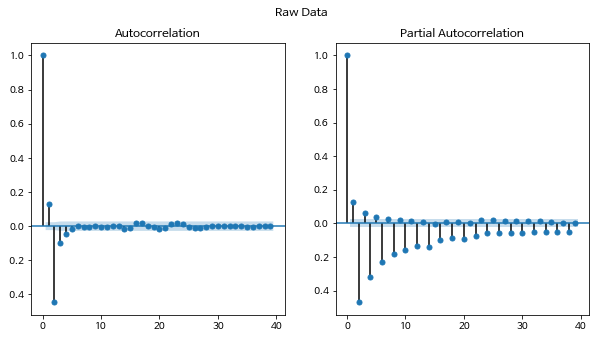

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train['총방류량'],ax = ax[0])  # Autocorrelation
sm.graphics.tsa.plot_pacf(diff_train['총방류량'],ax = ax[1]); # Partial Autocorrelation

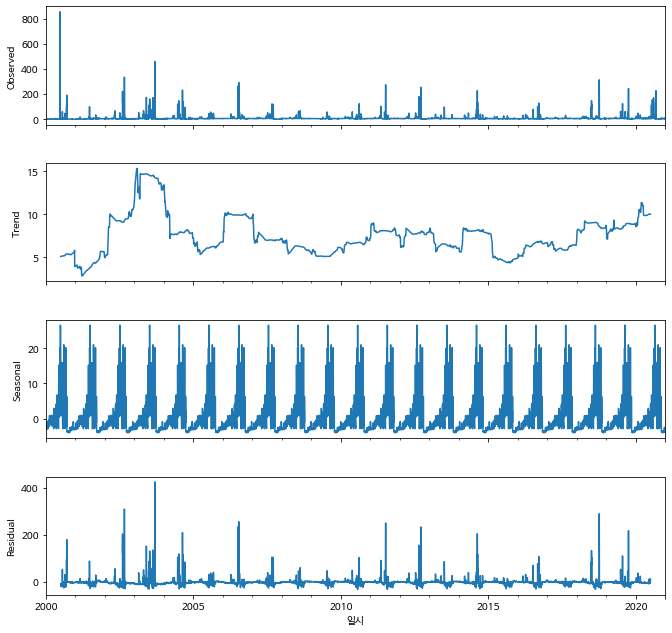

In [ ]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(data['유입량'], model = 'additive', freq = 368) # annual
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

## MinMaxScaler

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


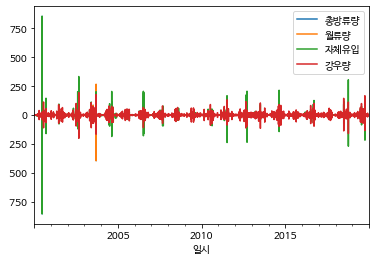

In [ ]:
diff_train.plot()

In [ ]:
scaler = MinMaxScaler()
print(scaler.fit(x_train))
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))


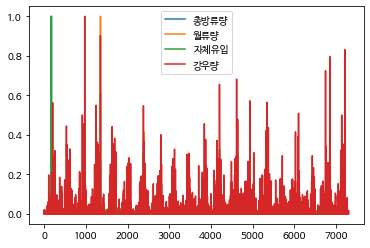

In [ ]:
plt.plot(x_train_scaled)
plt.legend(['총방류량', '월류량', '자체유입', '강우량'])

In [ ]:
print(x_train_scaled.shape)

(7305, 4)


In [ ]:
print(y_train.shape)

(7305, 1)


## EDA

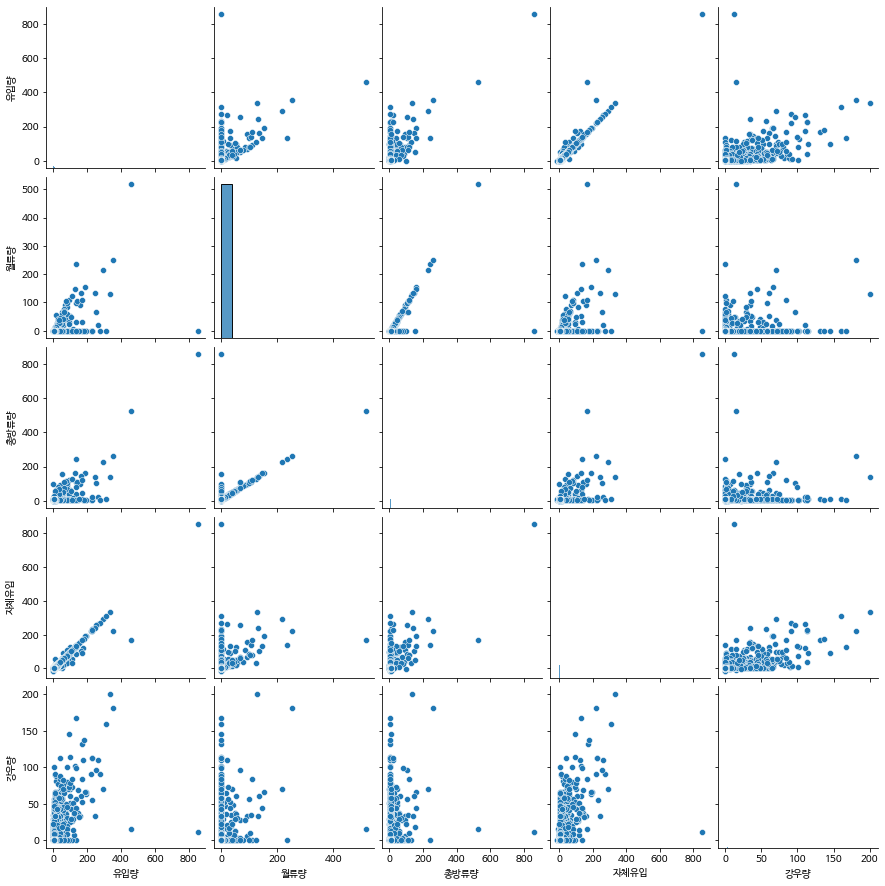

In [ ]:
sns.pairplot(wanted_data)

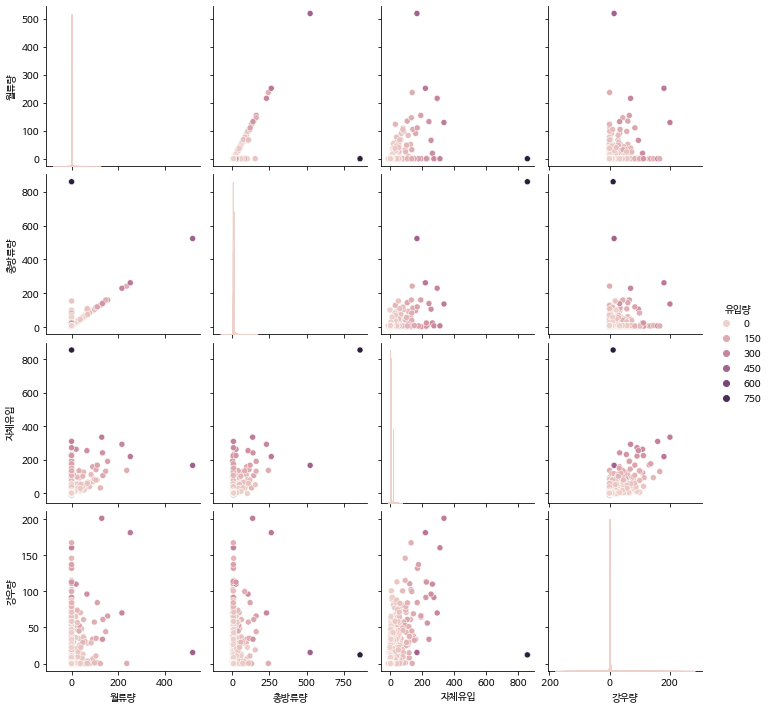

In [ ]:
sns.pairplot(wanted_data, hue='유입량')

## Evaluation Criteria

6개의 평가지표를 사용할 예정이다.

1. MAE
$$MAE = \frac{\sum_{i = 1}^N |{ y_{pred}} - y|}{N}$$
2. MSE
$$MSE = \frac{1}{N} \sum_{i = 1}^N (y - y_{pred})^2$$
3. RMSE
$$RMSE = \sqrt{\frac{\sum_{i = 1}^N (y - y_{pred})^2}{N}}$$
4. NSE
$$NSE = 1 - \frac{\sum_{i = 1}^N (y - y_{pred})^2}{\sum_{i = 1}^N(y - \bar y_{pred})^2} $$
5. MAPE
$$MAPE = \sum_{i = 1}^N (y_{pred} - y) \times \frac{100}{N} \% $$
6. NMAE
$$NMAE = \frac{1}{N} \sum_{i = 1}^N \left|{\frac{y - y_{pred}}{y}} \right|$$
7. AIC
8. BIC

In [ ]:
def MAE(y, y_pred):
  return np.mean(np.abs(y - y_pred))

In [ ]:
def MSE(y, y_pred):
  return np.mean(np.square(y - y_pred))

In [ ]:
def RMSE(y, y_pred):
  return np.sqrt(np.mean(np.square(y - y_pred)))

In [ ]:
def NSE(y, y_pred):
  return 1 - np.sum(np.square(y - y_pred)) / np.sum(np.square(y - np.mean(y_pred)))

In [ ]:
def MAPE(y, y_pred):
  return np.mean(np.abs((y_pred) - y) * 100)

In [ ]:
def NMAE(y, y_pred):
  return np.mean(np.abs((y - y_pred) / y))